In [324]:
import numpy as np
import noise, math
from matplotlib import pyplot as plt
from scipy.spatial import Voronoi
from skimage.draw import polygon

In [325]:
SIZE = 512
POINTS = 512
SEED = 1

In [326]:
def relax(points, size, k=10):
    new_points = points.copy()
    for _ in range(k):
        vor = Voronoi(new_points)
        new_points = []
        for _, region in enumerate(vor.regions):
            if len(region) == 0 or -1 in region: 
                continue
            poly = np.array([vor.vertices[i] for i in region])
            center = poly.mean(axis=0)
            new_points.append(center)
        new_points = np.array(new_points).clip(0, size)
    return new_points

points = relax(np.random.randint(0, SIZE, (POINTS, 2)), SIZE, 3)

In [327]:
vor = Voronoi(points)

In [328]:
def gen_voronoi_map(vor, size):
    voronoi_map = np.zeros((size, size))
    for i, region in enumerate(vor.regions):
        if (len(region) == 0) or (-1 in region): 
            continue
        x, y = np.array([vor.vertices[i][::-1] for i in region]).T
        polygon_x, polygon_y = polygon(x, y)
        in_borders = np.where((0 <= polygon_x) & (polygon_x < size) & (0 <= polygon_y) & (polygon_y < size))
        polygon_x, polygon_y = polygon_x[in_borders], polygon_y[in_borders]
        voronoi_map[polygon_x, polygon_y] = i
    return voronoi_map

voronoi_map = gen_voronoi_map(vor, SIZE)
%timeit voronoi_map = gen_voronoi_map(vor, SIZE)
# 84.3 ms - 100ms ± 4.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

93.7 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


218 ms ± 5.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


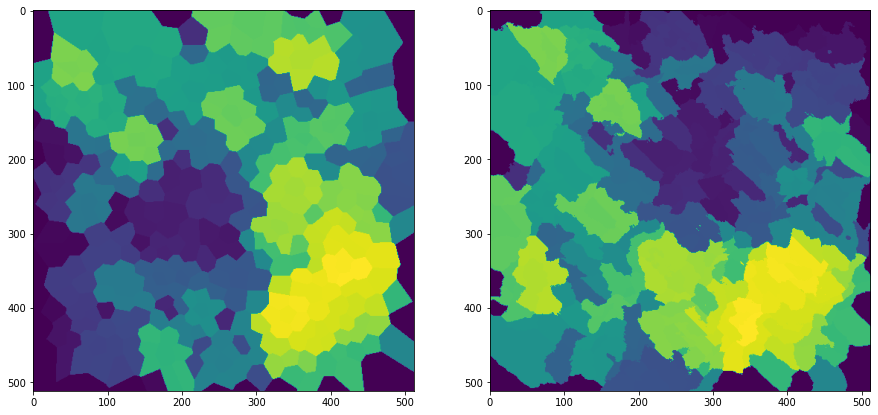

In [329]:
def noise_map(size, seed, scale=100., octaves=6, persistence=0.5, lacunarity=2.0):
    return np.array([[
        noise.snoise3(
            x/scale,
            y/scale,
            seed,
            octaves=octaves,
            persistence=persistence,
            lacunarity=lacunarity
        ) for x in range(size)] for y in range(size)])

def blure_boundaries(vor_map, disp, size, seed):
    map_noise = noise_map(size, seed, 100.)
    noise = np.dstack([map_noise, map_noise])
    noise = np.indices((size, size)).T + disp*noise
    noise = noise.clip(0, size-1).astype('int')
    blurred_vor_map = vor_map[noise[:,:,0], noise[:,:,1]]
    return blurred_vor_map

blurred_vor_map = blure_boundaries(voronoi_map, math.floor(POINTS/15), SIZE, SEED)
%timeit blurred_vor_map = blure_boundaries(voronoi_map, math.floor(POINTS/15), SIZE, SEED)
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(voronoi_map)
axes[1].imshow(blurred_vor_map)
plt.savefig('blurring.png', bbox_inches='tight')
# 213 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

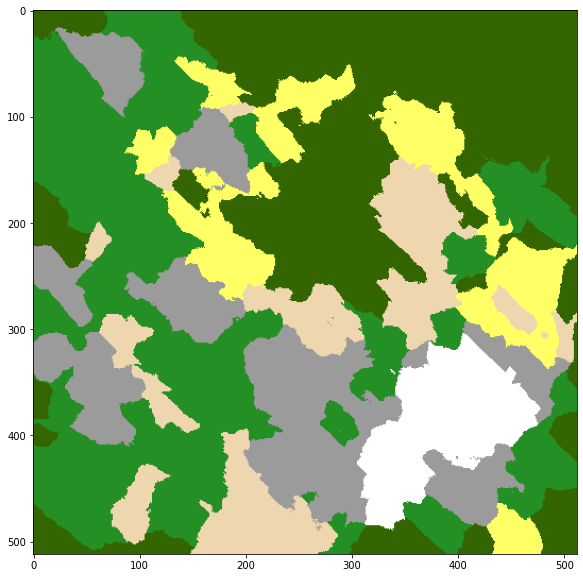

In [330]:
def add_color(blurred_map, points, biomes): 
    biomes_map = np.empty(blurred_map.shape+(3,))
    val = blurred_map/points
    biomes_map[val < 0.2] = biomes['TAIGA']
    biomes_map[(val >= 0.2) & (val < 0.3)] = biomes['BEACH']
    biomes_map[(val >= 0.3) & (val < 0.4)] = biomes['SAND']
    biomes_map[(val >= 0.4) & (val < 0.65)] = biomes['GREEN']
    biomes_map[(val >= 0.65) & (val < 0.8)] = biomes['MOUNTAIN']
    biomes_map[val >= 0.8] = biomes['SNOW']
    return biomes_map

biomes = {  'TAIGA':[51, 102, 0],
            'BEACH':[238, 214, 175],
            'SAND':[255, 255, 102],
            'GREEN':[36, 143, 36],
            'MOUNTAIN':[155,155,155],
            'SNOW':[255,255,255],
            'WATER':[0, 0, 179] }
biomes_map = add_color(blurred_vor_map, POINTS, biomes)
plt.figure(figsize=(10, 10))
fig = plt.imshow(biomes_map.astype('int'))
plt.savefig('biomes.png', bbox_inches='tight')

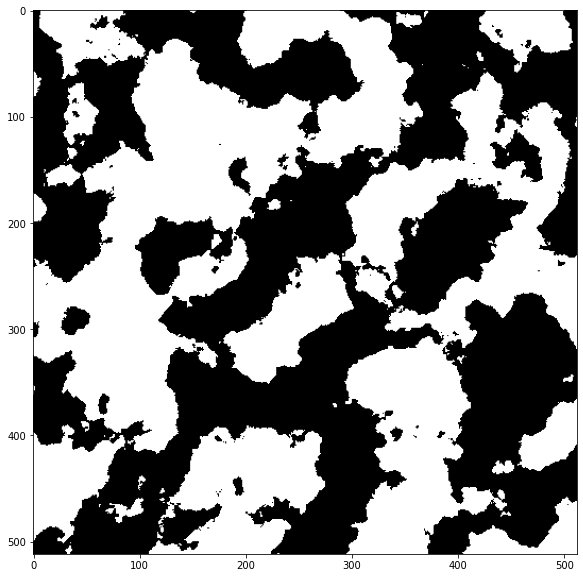

In [331]:

def add_sea(biomes_map, size, scale, seed, octaves, sea_col):
    height_map = noise_map(size, seed, scale, octaves)
    biomes_map[height_map > 0] = sea_col
    return height_map, biomes_map.astype(int)

height_map, biomes_sea_map = add_sea(biomes_map=biomes_map, size=SIZE, scale=100., seed=SEED, octaves=8, sea_col=biomes['WATER'])
plt.figure(figsize=(10, 10))
plt.imshow(height_map>0, cmap='gray')
plt.savefig('height.png', bbox_inches='tight')

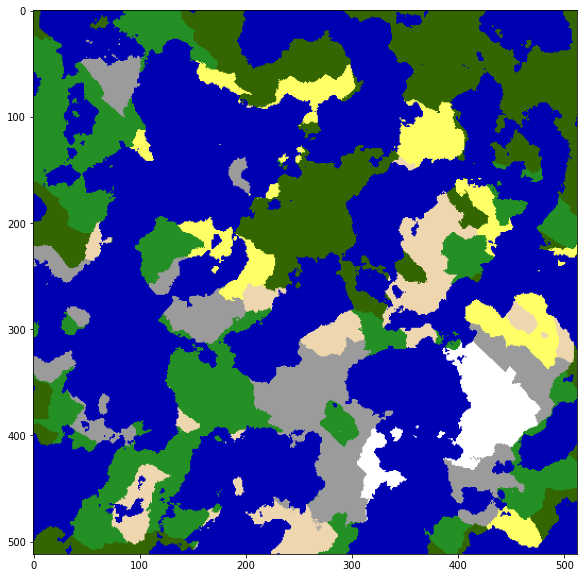

In [332]:
plt.figure(figsize=(10, 10))
plt.imshow(biomes_sea_map)
plt.savefig('sea_and_biomes.png', bbox_inches='tight')

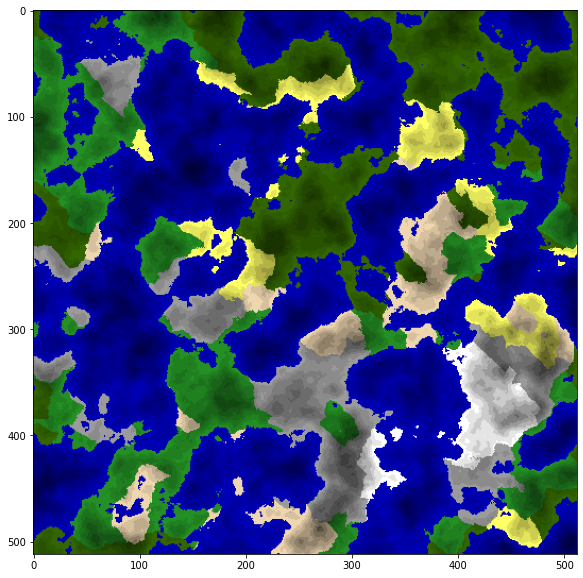

In [333]:
def add_height(biomes_sea_map, height_map):
    detail_map = biomes_sea_map*(1-0.1*(abs(height_map[..., np.newaxis])//0.1))
    return detail_map.astype(int)

final_map = add_height(biomes_sea_map=biomes_sea_map, height_map=height_map)
plt.figure(figsize=(10, 10))
plt.imshow(final_map)
plt.savefig('final_map.png', bbox_inches='tight')